In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))
print(f"notebook_dir: {notebook_dir}")
print(f"Calculated project_root: {project_root}")
print(f"Current sys.path (before modification): {sys.path}")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

notebook_dir: d:\02_Projects\Dev\ReflectoLearn\notebooks
Calculated project_root: d:\02_Projects\Dev\ReflectoLearn
Current sys.path (before modification): ['C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\python312.zip', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\DLLs', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none\\Lib', 'C:\\Users\\isaac\\AppData\\Roaming\\uv\\python\\cpython-3.12.11-windows-x86_64-none', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv', '', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages', 'D:\\02_Projects\\Dev\\ReflectoLearn\\src', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\win32\\lib', 'd:\\02_Projects\\Dev\\ReflectoLearn\\.venv\\Lib\\site-packages\\Pythonwin']


In [2]:
%reload_ext autoreload
%autoreload 2

D:\02_Projects\Dev\ReflectoLearn\src\reflectolearn\data_processing\fitting.py:21: RuntimeWarning: invalid value encountered in sqrt
  s_cor = np.sqrt(q_crit**2 - q_nm**2)


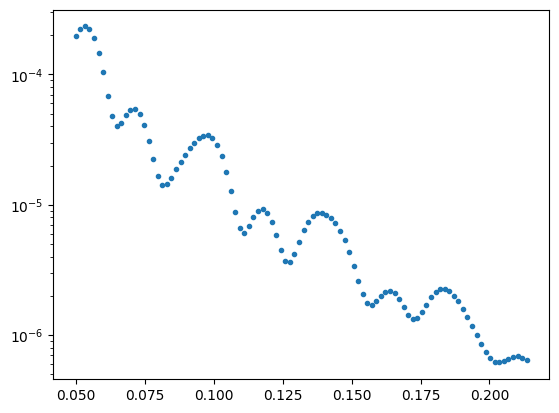

D:\02_Projects\Dev\ReflectoLearn\src\reflectolearn\data_processing\fitting.py:64: RuntimeWarning: divide by zero encountered in divide
  return amp / np.power(x, ex)


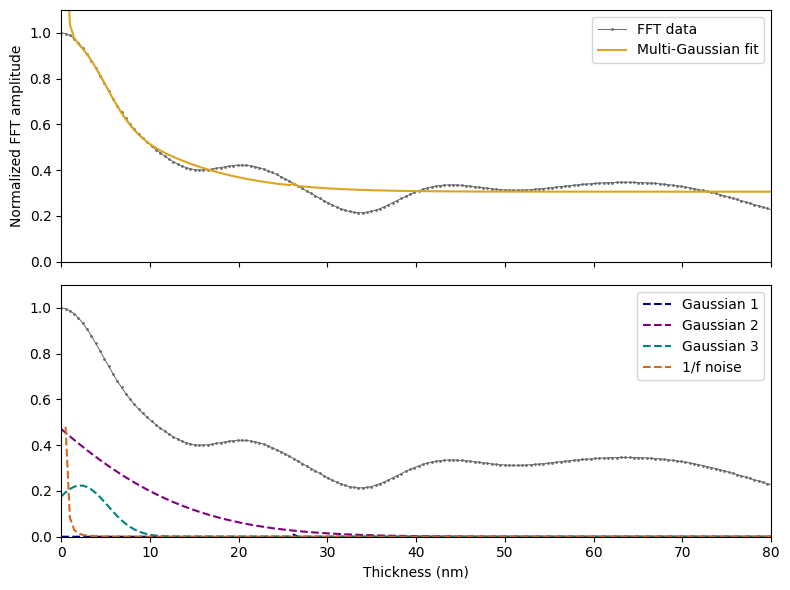

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from reflectolearn.data_processing.simulate import make_multifilm
from reflectolearn.data_processing.fitting import (
    tth2qz_by_energy, estimate_qc, analyze_xrr_fft, plot_xrr_fft
)

beam_energy = 8.04751
tth = np.linspace(0.7, 3, 100)
q = tth2qz_by_energy(tth, beam_energy)

data = make_multifilm(3, q, add_noise=False)
dat = np.stack([q, data["R"]], axis=1)

crit_q = estimate_qc(q, data["R"])
fft_x, fft_y_norm, popt_noise, popt_gauss3 = analyze_xrr_fft(dat, crit_q)

# Plot results
plt.plot(dat[:,0], dat[:,1], ".")
plt.yscale("log")
plt.show()

plot_xrr_fft(fft_x, fft_y_norm, popt_gauss3)
